### Evaluation Metrics for models
 Code include creating the dataframe from the JSON file. Please run from the starting, until get "new_df", which is the final dataframe having features and target.

In [3]:
import json
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def parse_awards(awards):
    """Extract the number of wins and nominations from the Awards field."""
    wins = re.search(r"(\d+) win", awards)
    nominations = re.search(r"(\d+) nomination", awards)
    total_wins = int(wins.group(1)) if wins else 0
    total_nominations = int(nominations.group(1)) if nominations else 0
    return total_wins, total_nominations

def extract_features_from_json(json_data):
    """Extract features from the given JSON movie data."""
    features = []
    for movie in json_data:
        # Year
        year = int(movie.get('Year', '0'))

        # Runtime
        runtime_str = movie.get('Runtime', '0 min')
        runtime = int(runtime_str.split()[0]) if runtime_str.split()[0].isdigit() else 0

        # Genre
        genres = movie.get('Genre', '').split(', ')
        num_genres = len(genres)

        # Director
        # director = movie.get('Director', 'Unknown')

        # Writer
        # writer = movie.get('Writer', 'Unknown')

        # Number of actors
        num_actors = len(movie.get('Actors', '').split(', '))

        # Language
        languages = movie.get('Language', '').split(', ')
        # number of languages
        num_languages = len(languages)

        # Country
        country = movie.get('Country', 'Unknown')
        # number of countries
        num_countries = len(country)

        # Awards
        awards = movie.get('Awards', '')
        wins, nominations = parse_awards(awards)

        # Metascore
        # metascore = int(movie.get('Metascore', '0')) if movie.get('Metascore', 'N/A') != 'N/A' else 0

        # BoxOffice
        box_office_str = movie.get('BoxOffice', '$0').replace('$', '').replace(',', '')
        box_office = int(box_office_str) if box_office_str.isdigit() else 0

        # IMDb Rating
        imdb_rating = float(movie.get('imdbRating', '0.0')) if movie.get('imdbRating', 'N/A') != 'N/A' else 0.0

        # Append extracted features
        features.append({
            'Title': movie.get('Title', ''),
            'Year': year,
            'Runtime': runtime,
            'NumGenres': num_genres,
            'Genres': genres,
            'NumActors': num_actors,
            'Languages': languages,
            'NumLanguages': num_languages,
            'NumCountries': num_countries,
            'Country': country,
            'Wins': wins,
            'Nominations': nominations,
            'BoxOffice': box_office,
            'IMDBRating': imdb_rating,
        })

    return pd.DataFrame(features)

# Load JSON data
json_file_path = "film_responses.json"  # Replace with your actual file path
with open(json_file_path, 'r', encoding='utf-8') as file:
    movie_data = json.load(file)

# Extract features
df = extract_features_from_json(movie_data)

# Drop rows with missing or zero IMDb ratings
df = df[df['IMDBRating'] > 0.0]
df.reset_index(drop=True, inplace=True)

# df = df[df['BoxOffice'] > 0.0]
# df.reset_index(drop=True, inplace=True)

# Add binary classification target (Good = 1, Bad = 0 based on IMDb rating)
df['Target'] = (df['IMDBRating'] > 7).astype(int)

df_all = pd.DataFrame() # df_all icinde IMDBRating sütunu da var
df_all = df
# Drop the 'IMDBRating' column from the DataFrame
df = df.drop(columns=['IMDBRating'])


# Display the resulting DataFrame
print(df.head())

               Title  Year  Runtime  NumGenres                   Genres  \
0  We Live in Public  2009       91          1            [Documentary]   
1   The Intouchables  2011      112          2          [Comedy, Drama]   
2         Swept Away  2002       89          2        [Comedy, Romance]   
3           Kick-Ass  2010      117          3  [Action, Comedy, Crime]   
4       12 Angry Men  1957       96          2           [Crime, Drama]   

   NumActors                  Languages  NumLanguages  NumCountries  \
0          3                  [English]             1            13   
1          3          [French, English]             2             6   
2          3  [English, Greek, Italian]             3            21   
3          3                  [English]             1            29   
4          3                  [English]             1            13   

                         Country  Wins  Nominations  BoxOffice  Target  
0                  United States     2           

In [4]:
# Assuming `df_features` is the raw dataset with a 'Target' column for labels
def generate_data_report(df):
    # Total number of samples
    total_samples = df.shape[0]

    # Categories and their counts
    category_counts = df['Target'].value_counts()
    categories = category_counts.index.tolist()
    samples_per_category = category_counts.values.tolist()

    # Dimensionality of the raw data
    raw_data_dimensionality = df.shape[1]

    # Create a DataFrame to display the report
    report_data = {
        "Metric": ["Number of Samples", "Categories", "Samples per Category", "Dimensionality of Raw Data"],
        "Value": [
            total_samples,
            f"{categories[0]} (Bad), {categories[1]} (Good)",
            f"{samples_per_category[0]} (Bad), {samples_per_category[1]} (Good)",
            raw_data_dimensionality
        ]
    }

    report_df = pd.DataFrame(report_data)
    return report_df

# Generate and display the report
report = generate_data_report(df)
print(report)

                       Metric                    Value
0           Number of Samples                     3280
1                  Categories        0 (Bad), 1 (Good)
2        Samples per Category  2156 (Bad), 1124 (Good)
3  Dimensionality of Raw Data                       14


In [5]:
def preprocess_movie_data(df):
    """
    Preprocess the movie dataset for machine learning and return processed datasets.

    Parameters:
    df (pd.DataFrame): The DataFrame containing extracted movie features.

    Returns:
    X_train_processed (pd.DataFrame): Preprocessed training features.
    X_test_processed (pd.DataFrame): Preprocessed testing features.
    y_train (pd.Series): Training target labels.
    y_test (pd.Series): Testing target labels.
    combined_df (pd.DataFrame): Combined DataFrame containing all processed data with a Train/Test indicator.
    """
    # Drop unnecessary columns
    df_features = df.drop(['Languages', 'Country'], axis=1)

    # Fill missing values in numerical features
    numeric_features = ['Year', 'Runtime', 'Wins', 'Nominations', 'BoxOffice']
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Replace missing values with the median
        ('scaler', MinMaxScaler())  # Scale features to [0, 1]
    ])

    # One-hot encode genres
    #one_hot_genres = pd.get_dummies(df_features['Genres'].apply(pd.Series).stack()).groupby(level=0).sum()
    #df_features = pd.concat([df_features, one_hot_genres], axis=1)
    #df_features = df_features.drop(['Genres'], axis=1)

    # Separate target from features
    X = df_features.drop('Target', axis=1)
    y = df_features['Target']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ],
        remainder='drop'  # Exclude other columns from passthrough
    )

    # Apply preprocessing to training and testing datasets
    X_train_numeric = preprocessor.fit_transform(X_train)
    X_test_numeric = preprocessor.transform(X_test)

    # Combine numeric features and one-hot encoded columns
    X_train_non_numeric = X_train.drop(columns=numeric_features)
    X_test_non_numeric = X_test.drop(columns=numeric_features)

    X_train_processed = pd.concat([
        pd.DataFrame(X_train_numeric, columns=numeric_features, index=X_train.index),
        X_train_non_numeric
    ], axis=1)

    X_test_processed = pd.concat([
        pd.DataFrame(X_test_numeric, columns=numeric_features, index=X_test.index),
        X_test_non_numeric
    ], axis=1)

    # Add 'Train/Test' indicator
    X_train_processed['Train/Test'] = 'Train'
    X_test_processed['Train/Test'] = 'Test'

    # Add 'Target' column back
    X_train_processed['Target'] = y_train
    X_test_processed['Target'] = y_test

    # Combine train and test datasets
    combined_df = pd.concat([X_train_processed, X_test_processed])

    return combined_df


In [6]:
res = preprocess_movie_data(df)
res

,Year,Runtime,Wins,Nominations,BoxOffice,Title,NumGenres,Genres,NumActors,NumLanguages,NumCountries,Train/Test,Target
233,0.482143,0.034100,0.007843,0.017241,0.026797,"The Good, the Bad and the Ugly",3,"[Adventure, Drama, Western]",3,2,41,Train,1
831,0.187500,0.005747,0.000000,0.000000,0.000000,Wasei Kingu Kongu,3,"[Short, Adventure, Horror]",3,2,5,Train,0
2659,0.866071,0.021648,0.000000,0.000000,0.000000,Farewell,3,"[Drama, Romance, Thriller]",3,3,6,Train,0
2496,0.446429,0.022797,0.000000,0.003448,0.000000,Rome Adventure,2,"[Drama, Romance]",3,2,13,Train,0
3101,0.892857,0.020881,0.027451,0.044828,0.000000,Chinese Zodiac,3,"[Action, Adventure, Comedy]",3,5,16,Train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,0.508929,0.020115,0.000000,0.000000,0.000148,The File of the Golden Goose,3,"[Action, Crime, Drama]",3,1,14,Test,0
1578,0.848214,0.022414,0.082353,0.155172,0.126990,Hairspray,3,"[Comedy, Drama, Musical]",3,1,37,Test,0
565,0.446429,0.021073,0.015686,0.013793,0.017153,Dr. No,3,"[Action, Adventure, Thriller]",3,3,29,Test,1
313,0.830357,0.022797,0.054902,0.051724,0.000000,The King and the Clown,2,"[Drama, History]",3,1,11,Test,1


new_df is created here, drop uncessary columns.

In [7]:
new_df = pd.DataFrame()
new_df = res.drop(['Title', 'Train/Test', 'Genres'], axis=1)
new_df

,Year,Runtime,Wins,Nominations,BoxOffice,NumGenres,NumActors,NumLanguages,NumCountries,Target
233,0.482143,0.034100,0.007843,0.017241,0.026797,3,3,2,41,1
831,0.187500,0.005747,0.000000,0.000000,0.000000,3,3,2,5,0
2659,0.866071,0.021648,0.000000,0.000000,0.000000,3,3,3,6,0
2496,0.446429,0.022797,0.000000,0.003448,0.000000,2,3,2,13,0
3101,0.892857,0.020881,0.027451,0.044828,0.000000,3,3,5,16,0
...,...,...,...,...,...,...,...,...,...,...
208,0.508929,0.020115,0.000000,0.000000,0.000148,3,3,1,14,0
1578,0.848214,0.022414,0.082353,0.155172,0.126990,3,3,1,37,0
565,0.446429,0.021073,0.015686,0.013793,0.017153,3,3,3,29,1
313,0.830357,0.022797,0.054902,0.051724,0.000000,2,3,1,11,1


In [9]:
def logistic_regression_analysis(res):

    import numpy as np
    import pandas as pd
    import time

    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import (
        accuracy_score,
        roc_auc_score,
        average_precision_score,
        precision_score,
        recall_score,
        f1_score
    )


    X = res.iloc[:, :-1].values.astype(float)  # Features (all columns except last)
    y = res.iloc[:, -1].values.astype(float)   # Target (last column)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )


    class LogisticRegressionScratch:
        def __init__(self, learning_rate=0.01, epochs=1000, regularization=None, reg_lambda=0.01):
            self.learning_rate = learning_rate
            self.epochs = epochs
            self.regularization = regularization
            self.reg_lambda = reg_lambda

        def sigmoid(self, z):
            return 1 / (1 + np.exp(-z))

        def compute_loss(self, h, y):
            m = len(y)
            if self.regularization == 'l2':
                reg_term = (self.reg_lambda / (2 * m)) * np.sum(np.square(self.weights))
            else:
                reg_term = 0
            return -1 / m * (np.dot(y, np.log(h)) + np.dot((1 - y), np.log(1 - h))) + reg_term

        def fit(self, X, y):

            X = np.array(X, dtype=float)
            y = np.array(y, dtype=float)

            m, n = X.shape
            self.weights = np.zeros(n, dtype=float)
            self.bias = 0.0
            self.losses = []

            for epoch in range(self.epochs):
                # Forward propagation
                z = np.dot(X, self.weights) + self.bias
                h = self.sigmoid(z)

                # Compute loss
                loss = self.compute_loss(h, y)
                self.losses.append(loss)

                # Backward propagation
                dw = (1 / m) * np.dot(X.T, (h - y))
                db = (1 / m) * np.sum(h - y)

                # Apply regularization if specified
                if self.regularization == 'l2':
                    dw += (self.reg_lambda / m) * self.weights

                # Update weights and bias
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db

                # Stopping criteria (if loss does not improve significantly)
                if epoch > 1 and abs(self.losses[-1] - self.losses[-2]) < 1e-6:
                    break

        def predict_proba(self, X):

            X = np.array(X, dtype=float)
            z = np.dot(X, self.weights) + self.bias
            return self.sigmoid(z)

        def predict(self, X):
            """
            Returns binary predictions for each sample in X (threshold = 0.5).
            """
            return (self.predict_proba(X) >= 0.5).astype(int)

    # Train logistic regression from scratch
    start_time = time.time()
    log_reg_scratch = LogisticRegressionScratch(
        learning_rate=0.1, epochs=1000, regularization='l2', reg_lambda=0.1
    )
    log_reg_scratch.fit(X_train, y_train)
    scratch_training_time = time.time() - start_time

    # Predictions (Training and Test)
    y_train_pred_scratch = log_reg_scratch.predict(X_train)
    y_test_pred_scratch = log_reg_scratch.predict(X_test)
    y_test_prob_scratch = log_reg_scratch.predict_proba(X_test)

    # Logistic Regression using Scikit-Learn
    start_time = time.time()
    log_reg_sklearn = LogisticRegression(
        max_iter=1000,
        penalty='l2',
        C=1/0.1,  # corresponds to reg_lambda = 0.1
        solver='lbfgs'
    )
    log_reg_sklearn.fit(X_train, y_train)
    sklearn_training_time = time.time() - start_time

    # Predictions (Training and Test)
    y_train_pred_sklearn = log_reg_sklearn.predict(X_train)
    y_test_pred_sklearn = log_reg_sklearn.predict(X_test)
    y_test_prob_sklearn = log_reg_sklearn.predict_proba(X_test)[:, 1]


    # Evaluate and Compare Performance

    # -- From Scratch --
    scratch_acc = accuracy_score(y_test, y_test_pred_scratch)
    scratch_auroc = roc_auc_score(y_test, y_test_prob_scratch)
    scratch_avg_precision = average_precision_score(y_test, y_test_prob_scratch)
    scratch_precision = precision_score(y_test, y_test_pred_scratch)
    scratch_recall = recall_score(y_test, y_test_pred_scratch)
    scratch_f1 = f1_score(y_test, y_test_pred_scratch)

    # -- Scikit-Learn --
    sklearn_acc = accuracy_score(y_test, y_test_pred_sklearn)
    sklearn_auroc = roc_auc_score(y_test, y_test_prob_sklearn)
    sklearn_avg_precision = average_precision_score(y_test, y_test_prob_sklearn)
    sklearn_precision = precision_score(y_test, y_test_pred_sklearn)
    sklearn_recall = recall_score(y_test, y_test_pred_sklearn)
    sklearn_f1 = f1_score(y_test, y_test_pred_sklearn)

    # Summarize results
    results = {
        "Metric": [
            "Accuracy",
            "AUROC",
            "Avg Precision",
            "Precision",
            "Recall",
            "F1-Score",
            "Training Time (s)"
        ],
        "From Scratch": [
            scratch_acc,
            scratch_auroc,
            scratch_avg_precision,
            scratch_precision,
            scratch_recall,
            scratch_f1,
            scratch_training_time
        ],
        "Scikit-Learn": [
            sklearn_acc,
            sklearn_auroc,
            sklearn_avg_precision,
            sklearn_precision,
            sklearn_recall,
            sklearn_f1,
            sklearn_training_time
        ],
    }

    results_df = pd.DataFrame(results)
    return results_df


In [10]:
results_df = logistic_regression_analysis(new_df)
results_df


<ipython-input-9-4038efcf6c2c>:44: RuntimeWarning: divide by zero encountered in log
  return -1 / m * (np.dot(y, np.log(h)) + np.dot((1 - y), np.log(1 - h))) + reg_term


,Metric,From Scratch,Scikit-Learn
0,Accuracy,0.675813,0.792683
1,AUROC,0.622366,0.798795
2,Avg Precision,0.491284,0.736589
3,Precision,0.628205,0.860963
4,Recall,0.144543,0.474926
5,F1-Score,0.235012,0.612167
6,Training Time (s),0.711674,0.158830


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import pandas as pd
import time

def random_forest_analysis(res):


    X = res.iloc[:, :-1].values
    y = res.iloc[:, -1].values

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Determine the number of trees using 5-fold cross-validation
    num_trees_options = [10, 50, 100, 200, 500]
    best_score = 0
    best_num_trees = 0

    for num_trees in num_trees_options:
        rf = RandomForestClassifier(n_estimators=num_trees, random_state=42)
        scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
        mean_score = scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            best_num_trees = num_trees

    start_time = time.time()
    final_rf = RandomForestClassifier(n_estimators=best_num_trees, random_state=42)
    final_rf.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Evaluate the model on training and test sets
    train_accuracy = final_rf.score(X_train, y_train)
    test_accuracy = final_rf.score(X_test, y_test)


    results = {
        "Best Num Trees": best_num_trees,
        "Cross-Validation Accuracy": best_score,
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Training Time (s)": training_time
    }

    results_df = pd.DataFrame([results])

    # Return the trained model, test sets, and the original results DataFrame
    return final_rf, X_test, y_test, results_df


In [9]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score
)

final_rf, X_test, y_test, rf_results = random_forest_analysis(new_df)

print("Initial Random Forest Results:")
display(rf_results)


y_pred = final_rf.predict(X_test)
y_prob = final_rf.predict_proba(X_test)[:, 1]

rf_acc = accuracy_score(y_test, y_pred)
rf_auroc = roc_auc_score(y_test, y_prob)
rf_avg_precision = average_precision_score(y_test, y_prob)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)

extra_results = {
    "Metric": ["Accuracy", "AUROC", "Avg Precision", "Precision", "Recall", "F1-Score"],
    "Random Forest": [rf_acc, rf_auroc, rf_avg_precision, rf_precision, rf_recall, rf_f1]
}
extra_metrics_df = pd.DataFrame(extra_results)

print("Additional Metrics for Random Forest:")
display(extra_metrics_df)


Initial Random Forest Results:


,Best Num Trees,Cross-Validation Accuracy,Train Accuracy,Test Accuracy,Training Time (s)
0,50,0.793127,0.999129,0.79878,0.578858


Additional Metrics for Random Forest:


,Metric,Random Forest
0,Accuracy,0.798780
1,AUROC,0.848997
2,Avg Precision,0.758173
3,Precision,0.762082
4,Recall,0.604720
5,F1-Score,0.674342


In [12]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import time
from cvxopt import matrix, solvers

class SVMFromScratch:
    def __init__(self, C=1):
        self.C = C

    def fit(self, X, y):
        m, n = X.shape

        # Prepare matrices for quadratic programming
        y = y.reshape(-1, 1) * 1.0
        X_y = X * y
        P = matrix(np.dot(X_y, X_y.T))
        q = matrix(-np.ones((m, 1)))
        G = matrix(np.vstack((-np.eye(m), np.eye(m))))
        h = matrix(np.vstack((np.zeros((m, 1)), np.ones((m, 1)) * self.C)))
        A = matrix(y.reshape(1, -1))
        b = matrix(0.0)

        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol['x']).flatten()

        sv = alphas > 1e-5
        self.alphas = alphas[sv]
        self.sv_X = X[sv]
        self.sv_y = y[sv].flatten()

        self.w = np.sum(self.alphas[:, None] * self.sv_y[:, None] * self.sv_X, axis=0)
        self.b = np.mean(self.sv_y - np.dot(self.sv_X, self.w))

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)
from sklearn.metrics import roc_auc_score, classification_report

def sklearn_svm_analysis(res):
    # Prepare dataset
    X = res.iloc[:, :-1].values
    y = res.iloc[:, -1].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Define parameter grid for GridSearch
    param_grid = {
        'C': [1, 10],
        'kernel': ['poly', 'rbf'],
        'gamma': ['scale', 'auto']
    }

    svc = SVC(probability=True)
    grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    grid_search_time = time.time() - start_time


    best_model = grid_search.best_estimator_
    print(best_model)
    train_accuracy = best_model.score(X_train, y_train)
    test_accuracy = best_model.score(X_test, y_test)

    results = {
        "Best Parameters": grid_search.best_params_,
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Grid Search Time (s)": grid_search_time
    }
    print(results)
    print(train_accuracy, test_accuracy)
    y_test_pred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)[:, 1]  # Probability for the positive class

    classification_rep = classification_report(y_test, y_test_pred)

    auroc = roc_auc_score(y_test, y_test_prob)

    print(f"Classification Report:\n{classification_rep}")
    print(f"AUROC: {auroc:.4f}")


    return pd.DataFrame([results])

### Runs for three hours, avoid rerunning

In [ ]:
sklearn_svm_analysis(new_df)

In [9]:
def compare_svm_methods(res):
    # Prepare dataset
    X = res.iloc[:, :-1].values
    y = res.iloc[:, -1].values
    y = np.where(y == 0, -1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # SVM from scratch
    start_time = time.time()
    svm_scratch = SVMFromScratch(C=1)
    svm_scratch.fit(X_train, y_train)
    scratch_time = time.time() - start_time

    y_train_pred_scratch = svm_scratch.predict(X_train)
    y_test_pred_scratch = svm_scratch.predict(X_test)

    train_accuracy_scratch = accuracy_score(y_train, y_train_pred_scratch)
    test_accuracy_scratch = accuracy_score(y_test, y_test_pred_scratch)

    # Scikit-learn SVM
    results_sklearn = sklearn_svm_analysis(res)

    # Combine results
    scratch_results = {
        "Model": "SVM from Scratch",
        "Train Accuracy": train_accuracy_scratch,
        "Test Accuracy": test_accuracy_scratch,
        "Training Time (s)": scratch_time
    }

    sklearn_results = {
        "Model": "Scikit-learn SVM",
        "Train Accuracy": results_sklearn.iloc[0]['Train Accuracy'],
        "Test Accuracy": results_sklearn.iloc[0]['Test Accuracy'],
        "Training Time (s)": results_sklearn.iloc[0]['Grid Search Time (s)']
    }

    return pd.DataFrame([scratch_results, sklearn_results])



In [13]:
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np
import time
# Prepare dataset
X = new_df.iloc[:, :-1].values
y = new_df.iloc[:, -1].values
y = np.where(y == 0, -1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def decision_function(X, model):
    return np.dot(X, model.w) + model.b

# SVM from scratch
start_time = time.time()
svm_scratch = SVMFromScratch(C=1)
svm_scratch.fit(X_train, y_train)
scratch_time = time.time() - start_time

y_train_pred_scratch = svm_scratch.predict(X_train)
y_test_pred_scratch = svm_scratch.predict(X_test)
y_test_decision_values = decision_function(X_test, svm_scratch)

train_accuracy_scratch = accuracy_score(y_train, y_train_pred_scratch)
test_accuracy_scratch = accuracy_score(y_test, y_test_pred_scratch)

# Calculate AUROC
auroc = roc_auc_score(y_test, y_test_decision_values)

# Generate the classification report
classification_rep = classification_report(y_test, y_test_pred_scratch)

# Print results
print(f"Classification Report:\n{classification_rep}")
print(f"AUROC: {auroc:.4f}")

     pcost       dcost       gap    pres   dres
 0: -1.6521e+03 -8.9788e+03  6e+04  4e+00  2e-11
 1: -1.0613e+03 -7.1552e+03  1e+04  6e-01  1e-11
 2: -9.8299e+02 -2.5363e+03  2e+03  2e-14  1e-11
 3: -1.1372e+03 -1.7121e+03  6e+02  1e-15  8e-12
 4: -1.1706e+03 -1.6011e+03  4e+02  2e-14  7e-12
 5: -1.2069e+03 -1.4768e+03  3e+02  1e-14  8e-12
 6: -1.2174e+03 -1.4422e+03  2e+02  1e-14  7e-12
 7: -1.2185e+03 -1.4415e+03  2e+02  2e-14  8e-12
 8: -1.2481e+03 -1.3522e+03  1e+02  4e-14  8e-12
 9: -1.2523e+03 -1.3413e+03  9e+01  7e-15  7e-12
10: -1.2548e+03 -1.3339e+03  8e+01  2e-14  8e-12
11: -1.2678e+03 -1.3054e+03  4e+01  2e-14  8e-12
12: -1.2706e+03 -1.3000e+03  3e+01  2e-14  8e-12
13: -1.2750e+03 -1.2916e+03  2e+01  8e-15  8e-12
14: -1.2769e+03 -1.2884e+03  1e+01  2e-15  8e-12
15: -1.2791e+03 -1.2849e+03  6e+00  2e-15  8e-12
16: -1.2801e+03 -1.2834e+03  3e+00  2e-14  8e-12
17: -1.2809e+03 -1.2823e+03  1e+00  7e-15  9e-12
18: -1.2812e+03 -1.2818e+03  6e-01  6e-15  9e-12
19: -1.2814e+03 -1.28

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.76      0.96      0.85       645
           1       0.83      0.42      0.56       339

    accuracy                           0.77       984
   macro avg       0.80      0.69      0.70       984
weighted avg       0.78      0.77      0.75       984

Logistic Regression Train Accuracy: 0.7722
Logistic Regression Test Accuracy: 0.7724
Logistic Regression Training Time: 0.0206 seconds

SVM Performance:
              precision    recall  f1-score   support

           0       0.76      0.96      0.84       645
           1       0.83      0.42      0.55       339

    accuracy                           0.77       984
   macro avg       0.79      0.69      0.70       984
weighted avg       0.78      0.77      0.74       984

SVM Train Accuracy: 0.7713
SVM Test Accuracy: 0.7693
SVM Training Time: 0.2070 seconds


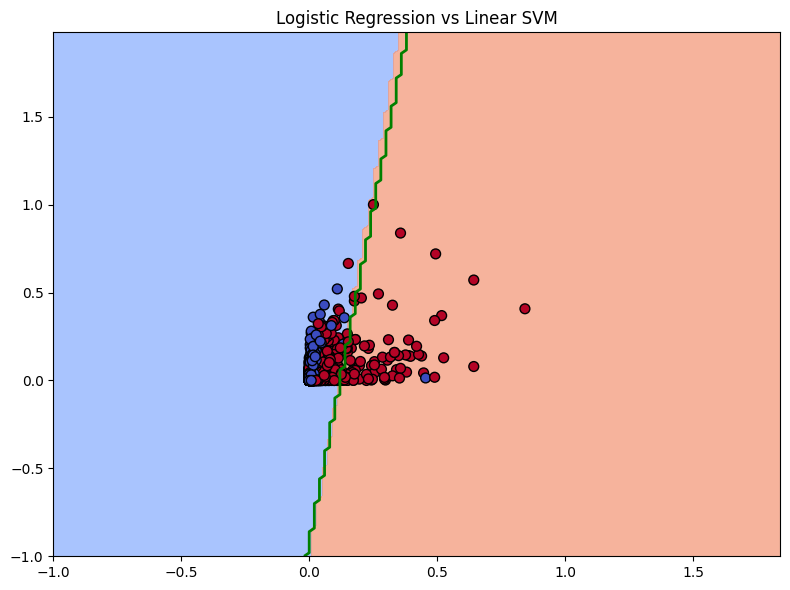

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import time


# Select relevant features and target, choose the most effective columns.
X = new_df[['Wins', 'BoxOffice']].values
y = new_df['Target'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Preprocessing, Scale numerical features
scaler = StandardScaler()

# Logistic Regression model
log_reg = Pipeline(steps=[
    ('scaler', scaler),
    ('classifier', LogisticRegression())
])

# Get the time for logistic
start_time = time.time()
log_reg.fit(X_train, y_train)
log_reg_train_time = time.time() - start_time

# SVM model
svm = Pipeline(steps=[
    ('scaler', scaler),
    ('classifier', SVC(kernel='linear'))
])

# Get the time for svm
start_time = time.time()
svm.fit(X_train, y_train)
svm_train_time = time.time() - start_time

# Evaluate models
log_reg_preds = log_reg.predict(X_test)
svm_preds = svm.predict(X_test)

# Print performance metrics
print("Logistic Regression Performance:")
print(classification_report(y_test, log_reg_preds))
log_reg_train_accuracy = accuracy_score(y_train, log_reg.predict(X_train))
log_reg_test_accuracy = accuracy_score(y_test, log_reg_preds)
print(f"Logistic Regression Train Accuracy: {log_reg_train_accuracy:.4f}")
print(f"Logistic Regression Test Accuracy: {log_reg_test_accuracy:.4f}")
print(f"Logistic Regression Training Time: {log_reg_train_time:.4f} seconds")

print("\nSVM Performance:")
print(classification_report(y_test, svm_preds))
svm_train_accuracy = accuracy_score(y_train, svm.predict(X_train))
svm_test_accuracy = accuracy_score(y_test, svm_preds)
print(f"SVM Train Accuracy: {svm_train_accuracy:.4f}")
print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")
print(f"SVM Training Time: {svm_train_time:.4f} seconds")

# Plot decision boundaries
def plot_decision_boundary(X, y, models, ax, title):
    # Create a mesh grid for plotting decision boundaries
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Plot decision boundaries for each model
    for model, label, color in models:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        if label == "Logistic Regression":
            ax.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.coolwarm, levels=[-0.1, 0.5, 1.1])
        elif label == "Linear SVM":
            ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='green')  # Green line for SVM decision boundary

    # Explicitly plot the data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm, s=50, alpha=1)
    ax.set_title(title)
    return scatter


fig, ax = plt.subplots(figsize=(8, 6))


models = [
    (log_reg.named_steps['classifier'], "Logistic Regression", 'blue'),
    (svm.named_steps['classifier'], "Linear SVM", 'red')
]

plot_decision_boundary(X_train, y_train, models, ax, "Logistic Regression vs Linear SVM")


plt.tight_layout()
plt.show()